In [ ]:
import sys
sys.path.append("..")  # pour que Python voie le dossier src/

from src.data_prep import build_datasets


In [ ]:
train_df, test_df = build_datasets()
train_df.shape, test_df.shape


In [ ]:
train_df.shape, test_df.shape
[c for c in train_df.columns if c.startswith("BUREAU_")][:20]


In [26]:
# Distribution brute
train_df["TARGET"].value_counts()


TARGET
0    282686
1     24825
Name: count, dtype: int64

In [25]:
# Distribution en % (déséquilibre)
train_df["TARGET"].value_counts(normalize=True)


TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Le dataset est très déséquilibré : seuls 8 % des clients sont en défaut. On ne pourra pas se contenter de l’accuracy et on privilégiera l’AUC-ROC, le recall de la classe minoritaire et un coût métier FN≫FP

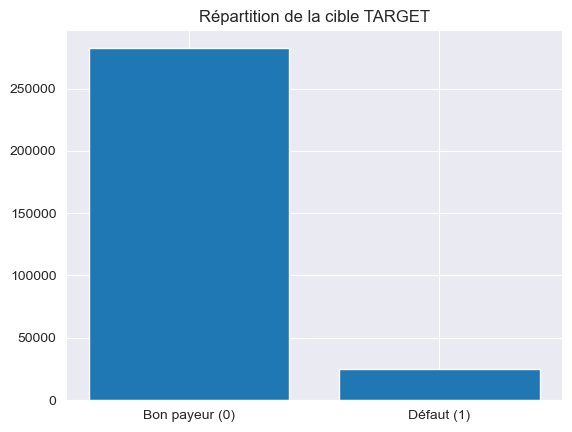

In [24]:
import matplotlib.pyplot as plt

target_counts = train_df["TARGET"].value_counts()
plt.bar(target_counts.index, target_counts.values)
plt.xticks([0, 1], ["Bon payeur (0)", "Défaut (1)"])
plt.title("Répartition de la cible TARGET")
plt.show()


In [27]:
missing_ratio = train_df.isna().mean().sort_values(ascending=False)
missing_ratio.head(30)


BUREAU_AMT_ANNUITY_MAX      0.739817
BUREAU_AMT_ANNUITY_MEAN     0.739817
BUREAU_AMT_ANNUITY_MIN      0.739817
COMMONAREA_MEDI             0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_AVG              0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
FLOORSMIN_AVG               0.678486
FLOORSMIN_MODE              0.678486
FLOORSMIN_MEDI              0.678486
YEARS_BUILD_MEDI            0.664978
YEARS_BUILD_MODE            0.664978
YEARS_BUILD_AVG             0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_MODE               0.593767
LANDAREA_AVG                0.593767
LANDAREA_MEDI               0.593767
BASEMENTAREA_AVG            0.585160
BASEMENTAREA_MODE           0.585160
BASEMENTAREA_MEDI           0.585160
EXT_SOURCE_1                0.563811
N

In [28]:
train_df["SK_ID_CURR"].duplicated().sum()


np.int64(0)

Il n’y a pas de doublons sur SK_ID_CURR après fusion avec les agrégats bureau.

In [29]:
train_df[["AMT_CREDIT", "AMT_INCOME_TOTAL", "TARGET"]].describe()

,AMT_CREDIT,AMT_INCOME_TOTAL,TARGET
count,3.075110e+05,3.075110e+05,307511.000000
mean,5.990260e+05,1.687979e+05,0.080729
std,4.024908e+05,2.371231e+05,0.272419
min,4.500000e+04,2.565000e+04,0.000000
25%,2.700000e+05,1.125000e+05,0.000000
50%,5.135310e+05,1.471500e+05,0.000000
75%,8.086500e+05,2.025000e+05,0.000000
max,4.050000e+06,1.170000e+08,1.000000


In [17]:
train_df["AGE_YEARS"] = (-train_df["DAYS_BIRTH"] / 365.25).round(1)
train_df[["AGE_YEARS", "DAYS_BIRTH"]].head()

,AGE_YEARS,DAYS_BIRTH
0,25.9,-9461
1,45.9,-16765
2,52.1,-19046
3,52.0,-19005
4,54.6,-19932


In [18]:
train_df[["AGE_YEARS", "TARGET"]].groupby("TARGET").mean()

,AGE_YEARS
TARGET,
0,44.183969
1,40.752709


On peut dire que les client les plus jeunes sont plus risqués

In [19]:
train_df.groupby("TARGET")[["AMT_INCOME_TOTAL", "AMT_CREDIT"]].mean()

,AMT_INCOME_TOTAL,AMT_CREDIT
TARGET,,
0,169077.722266,602648.282002
1,165611.760906,557778.527674


In [20]:
train_df.groupby("TARGET")[["AMT_INCOME_TOTAL", "AMT_CREDIT"]].median()

,AMT_INCOME_TOTAL,AMT_CREDIT
TARGET,,
0,148500.0,517788.0
1,135000.0,497520.0


un effort financier plus lourd → plus de risque de défaut.

In [21]:
train_df["CREDIT_INCOME_RATIO"] = train_df["AMT_CREDIT"] / train_df["AMT_INCOME_TOTAL"]
train_df.groupby("TARGET")["CREDIT_INCOME_RATIO"].median()

TARGET
0    3.266653
1    3.253143
Name: CREDIT_INCOME_RATIO, dtype: float64

Pas de grand diff

In [22]:
cols = ["BUREAU_AMT_CREDIT_SUM_DEBT_SUM", "BUREAU_AMT_CREDIT_SUM_SUM"]
train_df[cols + ["TARGET"]].groupby("TARGET").mean()

,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_SUM
TARGET,,
0,637271.677587,1.972495e+06
1,680978.726472,1.756600e+06


les clients déjà très endettés à l’extérieur ont plus de risque de défaut.

In [30]:
target_counts = train_df["TARGET"].value_counts()
print(target_counts)
print(target_counts / len(train_df))

TARGET
0    282686
1     24825
Name: count, dtype: int64
TARGET
0    0.919271
1    0.080729
Name: count, dtype: float64


In [ ]:
app_train.shape
app_test.shape
app_train.head()
app_train.info()



In [ ]:
app_train["SK_ID_CURR"].nunique(), len(app_train)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

target_counts = app_train["TARGET"].value_counts()
print(target_counts)
print(target_counts / len(app_train))

sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title("Distribution de la cible TARGET")
plt.xlabel("TARGET (0 = bon, 1 = défaut)")
plt.ylabel("Nombre de clients")

plt.savefig("../reports/figures/target_distribution.png",)
plt.show()

In [ ]:
missing_ratio = app_train.isna().mean().sort_values(ascending=False)
missing_ratio.head(20)

In [16]:
import matplotlib.pyplot as plt

missing_counts = app_train.isna().sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
missing_counts.head(40).plot(kind='bar')
plt.title("Top 20 Missing Values per Feature")
plt.ylabel("Number of missing values")
plt.tight_layout()
plt.savefig("../reports/figures/Top_20_missing_values.png",)
plt.show()



NameError: name 'app_train' is not defined

In [15]:

import missingno as msno

plt.figure(figsize=(16, 6))
msno.bar(app_train)  # or app_train[cols_with_missing]
plt.xticks(rotation=90)  # rotate names to read them
plt.tight_layout()
plt.savefig("../reports/figures/missing_values.png",)
plt.show()


NameError: name 'app_train' is not defined

<Figure size 1600x600 with 0 Axes>

In [ ]:
(bureau["SK_ID_CURR"].nunique(),len(bureau))
previous_application["SK_ID_CURR"].nunique(),len(previous_application)
POS_CASH_balance["SK_ID_PREV"].nunique(), len(POS_CASH_balance)
credit_card_balance["SK_ID_PREV"].nunique(), len(credit_card_balance)
installments_payments["SK_ID_PREV"].nunique(), len(installments_payments)
bureau_balance["SK_ID_BUREAU"].nunique(), len(bureau_balance)


In [ ]:
print("bureau            :", bureau["SK_ID_CURR"].nunique(), len(bureau))
print("previous_app      :", previous_application["SK_ID_CURR"].nunique(), len(previous_application))
print("POS_CASH (pos)    :", POS_CASH_balance["SK_ID_PREV"].nunique(), len(POS_CASH_balance))
print("credit_card       :", credit_card_balance["SK_ID_PREV"].nunique(), len(credit_card_balance))
print("installments      :", installments_payments["SK_ID_PREV"].nunique(), len(installments_payments))
print("bureau_balance    :", bureau_balance["SK_ID_BUREAU"].nunique(), len(bureau_balance))


In [ ]:
import numpy as np

# colonnes numériques et catégorielles
num_cols_bureau = bureau.select_dtypes(include=[np.number]).columns.drop("SK_ID_CURR")
cat_cols_bureau = bureau.select_dtypes(include=["object"]).columns

# 1) Agrégations numériques
bureau_num_agg = bureau.groupby("SK_ID_CURR")[num_cols_bureau].agg(["mean", "max", "min", "sum"])
bureau_num_agg.columns = ["BUREAU_" + "_".join(col).upper() for col in bureau_num_agg.columns]

# 2) Catégorielles : one-hot + moyenne (fréquence)
bureau_cat = pd.get_dummies(bureau[["SK_ID_CURR"] + list(cat_cols_bureau)], columns=cat_cols_bureau)
bureau_cat_agg = bureau_cat.groupby("SK_ID_CURR").mean()
bureau_cat_agg.columns = ["BUREAU_" + col.upper() for col in bureau_cat_agg.columns]

# 3) Fusion num + cat au niveau client
bureau_agg = bureau_num_agg.join(bureau_cat_agg, how="left")
bureau_agg.head()


In [ ]:
app_train_enriched = app_train.merge(bureau_agg, on="SK_ID_CURR", how="left")
app_train_enriched.shape


In [ ]:
cat_cols_bureau = bureau.select_dtypes(include=["object"]).columns


In [ ]:
bureau_num_agg = bureau.groupby("SK_ID_CURR")[num_cols_bureau].agg(["mean", "max", "min", "sum"])
print(bureau_num_agg)


In [ ]:
bureau_num_agg.columns = ["BUREAU_" + "_".join(col).upper() for col in bureau_num_agg.columns]

In [ ]:
bureau_cat = pd.get_dummies(
    bureau[["SK_ID_CURR"] + list(cat_cols_bureau)],
    columns=cat_cols_bureau
)

In [ ]:
bureau_cat_agg = bureau_cat.groupby("SK_ID_CURR").mean()

In [ ]:
bureau_cat_agg.columns = ["BUREAU_" + col.upper() for col in bureau_cat_agg.columns]

In [ ]:
bureau_agg = bureau_num_agg.join(bureau_cat_agg, how="left")
print(bureau_agg)


In [ ]:
app_train_merged = app_train.merge(bureau_agg, on="SK_ID_CURR", how="left")
app_test_merged  = app_test.merge(bureau_agg, on="SK_ID_CURR", how="left")